In [1]:
from matplotlib import pyplot as plt
import random
from copy import deepcopy
import networkx as nx
import callable
import time
import os
import numpy as np
from tabulate import tabulate
from time import perf_counter

In [2]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        if degree > maxDegree:
            maxDegree = degree
            
    return maxDegree

In [3]:
def normEdge(u, v):
    return (u, v) if u < v else (v, u)

In [4]:
def calcConflicts(edges, edgesIndex, solution, neighbourhood):
    num  = 0
    
    for i in range(len(edges)):
        edge = edges[i]
        # edge = normEdge(*edges[i])
        myNeighbours = neighbourhood[edge]

        for nei in myNeighbours:
            idx = edgesIndex[nei]
            if solution[idx] == solution[i]:
                num += 1
        
    return (num // 2)


In [5]:
def recalcConflicts(edges, edgesIndex, oldConf, solution, neighbourhood, oldColour, newColour, i):
    num = 0

    edge = edges[i]
    myNeighbours = neighbourhood[edge]

    for nei in myNeighbours:
        idx = edgesIndex[nei]
        if solution[idx] == oldColour:
            num -= 1
        if solution[idx] == newColour:
            num += 1
    
    return oldConf + num


In [6]:
def getNeighbours(graph, edges):
    neighbourhood = {normEdge(u, v): [] for _, (u, v) in enumerate(graph.edges())} 


    for edge in edges:
        u, v = edge
        uNei = list(graph.neighbors(u))
        vNei = list(graph.neighbors(v))
        uNei.remove(v)
        vNei.remove(u)
        mapa = {}

        for i in uNei:
            nei = normEdge(u, i)
            neighbourhood[edge].append(nei)
            mapa[nei] = True

        for i in vNei:
            nei = normEdge(v, i)
            if nei not in mapa:
              neighbourhood[edge].append(nei)

    return neighbourhood

In [7]:
def shakingRand(solution, maxDegree, _edges, _neighbourhood, _edgesIndex, k):

    
    newSolution = deepcopy(solution)
    chosen = random.sample(range(len(solution)),k)
    
    for i in chosen:
        newSolution[i] = random.randrange(1, maxDegree+1)
    return newSolution

In [8]:
def shakingSwap(solution, _maxDegree, _edges, _neighbourhood, _edgesIndex, k):
    newSolution = deepcopy(solution)

    for _ in range(k):
        newSolution = np.random.permutation(newSolution)

    
    return newSolution.tolist()



In [9]:
def shakingNeigh(solution, maxDegree, edges, neighbourhood, edgesIndex, _k):
    newSolution = deepcopy(solution)
    i = random.randrange(len(newSolution))
    edge = edges[i]

    myNeis = neighbourhood[edge]
    for nei in myNeis:
        idx = edgesIndex[nei]
        newSolution[idx] = random.randrange(1,maxDegree+1)
    return newSolution


In [10]:
def confIndices(solution, edges, edgesIndex, neighbourhood):
    conflictingIndices = []

    for i in range(len(edges)):
        # edge = normEdge(*edges[i])
        edge = edges[i]
        myNeighbours = neighbourhood[edge]

        for nei in myNeighbours:
            idx = edgesIndex[nei]
            if solution[idx] == solution[i]:
                conflictingIndices.append(i)
                break
    
    return conflictingIndices

In [11]:
def shakingConf(solution, maxDegree, edges, neighbourhood, edgesIndex, k):
    
    newSolution = deepcopy(solution)
    conflictingIndices = confIndices(newSolution, edges, edgesIndex, neighbourhood)

    n = len(conflictingIndices)
    if n == 0:
        return newSolution
    
    chosen = random.sample(conflictingIndices, min(k, n))

    for i in chosen:
        newSolution[i] = random.randrange(1, maxDegree + 1)

    return newSolution

In [12]:
def lsFirst(edges, edgesIndex, solution, fitness, maxDegree, neighbourhood):
    newSolution = deepcopy(solution)
    improved = True

    while improved:
        improved = False
        indices = list(range(len(solution)))
        random.shuffle(indices)

        for i in indices:
            oldColour = newSolution[i]
            for colour in range(1,maxDegree+1):
                if colour == oldColour:
                    continue
                newSolution[i] = colour
                newFitness = recalcConflicts(edges, edgesIndex, fitness, newSolution, neighbourhood, oldColour, colour, i)
                if newFitness < fitness:
                    fitness = newFitness
                    improved = True
                    break
                else:
                    newSolution[i] = oldColour
    return newSolution, fitness


In [13]:
def lsBest(edges, edgesIndex, solution, fitness, maxDegree, neighbourhood):
    newSolution = deepcopy(solution)
    improved = True

    while improved:
        improved = False
        bestFitness = fitness
        bestIdx = -1
        bestColour = -1

        for i in range(len(solution)):
            oldColour = newSolution[i]
            for colour in range(1,maxDegree+1):
                if colour == oldColour:
                    continue
                newSolution[i] = colour
                newFitness = recalcConflicts(edges, edgesIndex, fitness, newSolution, neighbourhood, oldColour, colour, i)
                if newFitness < bestFitness:
                    bestFitness = newFitness
                    bestIdx = i
                    bestColour = colour
                newSolution[i] = oldColour
        
        if bestIdx != -1:
            newSolution[bestIdx] = bestColour
            fitness = bestFitness
            improved = True

    return newSolution, fitness


In [14]:
def lsTabu(edges, edgesIndex, solution, fitness, maxDegree, neighbourhood):

    bestSolution = deepcopy(solution)
    currentSolution = deepcopy(solution)
    bestFitness = fitness
    currentFitness = fitness

    tabuStep = 7
    tabuList = {}

    iteration = 0

    while iteration < 500 and bestFitness > 0:
        
        iteration += 1
        bestMoveFitness = float('inf')
        bestMove = None

        for i in range(len(solution)):
            oldColour = currentSolution[i]
            for colour in range(1,  maxDegree + 1):
                if oldColour == colour:
                    continue
                currentSolution[i] = colour
                newFitness = recalcConflicts(edges, edgesIndex, currentFitness, currentSolution, neighbourhood, oldColour, colour, i)
                currentSolution[i] = oldColour

                move = (i, oldColour)
                isTabu = tabuList.get(move, 0) > iteration

                if isTabu and newFitness >= bestFitness:
                    continue
                if newFitness < bestMoveFitness:
                    bestMoveFitness = newFitness
                    bestMove = (i, colour, oldColour)

        if bestMove is None:
            break

        i, newColour, oldColour = bestMove
        currentSolution[i] = newColour
        currentFitness = bestMoveFitness

        tabuList[(i, oldColour)] = iteration + tabuStep

        if currentFitness < bestFitness:
            bestFitness = currentFitness
            bestSolution = deepcopy(currentSolution)
    
    return bestSolution, bestFitness

In [15]:
def initialize(graph, max_degree):
    return [random.randrange(1,max_degree + 1) for _ in range(len(graph.edges))]

In [16]:
def vns(graph, maxDegree, maxTime, neighRange, probVal, localSearch: callable, shaking: callable):
    
    startTime = perf_counter()
    solution = initialize(graph,maxDegree)

    edges = [normEdge(u, v) for (u,v) in graph.edges()]
    edgesIndex = {normEdge(u, v) : i for i, (u, v) in enumerate(edges)}
    neighbourhood = getNeighbours(graph, edges)


    fitness = calcConflicts(edges, edgesIndex, solution, neighbourhood)

    # for it in range(maxIters):
    # k = 1
    while perf_counter() - startTime < maxTime:
        # for k in range(1,neighRange+1):
        # while k <= neighRange:
        for k in range(1,neighRange):
            
            newSolution = shaking(solution, maxDegree, edges,neighbourhood, edgesIndex, k)
            newFitness = calcConflicts(edges, edgesIndex, newSolution, neighbourhood)
            newSolution, newFitness = localSearch(edges, edgesIndex, newSolution, newFitness, maxDegree, neighbourhood)

            if newFitness < fitness or (newFitness == fitness and random.random() < probVal):
                fitness = newFitness
                solution = deepcopy(newSolution)
                # k = 1
            
                # print(f"Time: {perf_counter()-startTime:.2f}s | Conflicts: {newFitness} | k: {k}", flush=True)
            # else: 
            #     k = (k % neighRange) + 1
            #     # k += 1
            if fitness == 0:
                return solution, fitness 


    return solution, fitness



In [17]:
def draw(graph, colouring):
    nx.draw(graph, edge_color=colouring,with_labels=True)
    plt.show()

In [18]:
def readGraph(filepath):

    graph = nx.Graph()
    numNodes: int
    edges = []

    with open(filepath) as f:
        lines = f.readlines()
        numNodes = int(lines[0].split()[2])
        edges = [tuple(map(int,line.split()[1:])) for line in lines[1:]]

    graph.add_nodes_from(range(1, numNodes + 1))
    graph.add_edges_from(edges)
    return graph


In [19]:
def getBest(result):
    return min(range(len(result)), key= lambda i : (result[i][2], result[i][-1]))    

In [20]:
def writeOutput(filename, table, foundMin: bool, maxDegree, alreadyPrint):
    with open(f'resultsVNS/{filename}', 'a') as file:
        if(not alreadyPrint):
            file.write(f"Graph can be coloured with {maxDegree} or {maxDegree + 1} colours. Class 1 or class 2 respectively.\n")
        
        file.write(table + "\n")
        message = ""
        if(foundMin):
            message = "Graph is class 1, meaning chromatix index is equal to the graph's degree."
        else:
            message = "No conflict-free colouring is found, therefore graph is classified as class 2."
        file.write(message)
        file.write("\n")

        file.close()
        


In [21]:
def solve(graph, iters, neighRange, prob, localSearch:callable, shaking: callable, nextMax):

    maxDegree = maxNumOfColours(graph) + nextMax
    startTime = time.time()

    solution, fitness = vns(graph, maxDegree, iters, neighRange, prob, localSearch, shaking)
    
    endTime = time.time()
    tim = endTime - startTime
    numColours = list(set(solution))

    return [localSearch.__name__, shaking.__name__, fitness, len(numColours), tim, solution, maxDegree]


Experimental graphs

In [22]:
def testRandomGraph(graph,graphName, vnsParams, nextMax):
    
    headers = ["localSearch", "shaking","num of conf/fitness", "num of colours", "time"]
    inserts = []
    colorsRes = []

    localSearches = [lsFirst, lsBest, lsTabu]
    shakings = [shakingRand, shakingSwap, shakingNeigh, shakingConf]
    foundMin = False

    for ls in localSearches:
        for shake in shakings:
            result = solve(graph, vnsParams['time'], vnsParams['neighbours'], vnsParams['prob'], ls,shake, nextMax)
            # print(f'{ls.__name__} {shake.__name__} done',flush=True)
            if result[2] == 0:
                foundMin = True
            inserts.append(result[:-2])
            colorsRes.append(result[-2])

    table = tabulate(inserts, headers=headers, tablefmt="fancy_grid",showindex=True)
    i = getBest(inserts)
    bestRes = inserts[i][2]
    print(f"Best:  {inserts[i][0]}, {inserts[i][1]}, time: {inserts[i][4]}. No. of conflicts {bestRes}")
    
    if foundMin:
        draw(graph, colorsRes[i])

    writeOutput(graphName, table, foundMin, result[-1], nextMax)

    return bestRes

In [23]:
vnsParams = {
    'time': 60,
    'prob': 0.5,
    'neighbours': 4
}

In [49]:
def saveGraph(name, graph):
    with open(f'tests/experimentalTests/{name}', 'w') as file:
        file.write(f'p edge {graph.number_of_nodes()} {graph.number_of_edges()}\n')
        for u,v in graph.edges():
            file.write(f'p {u+1} {v+1}\n')

Random Graphs: n number of vertexes and p probability of edge creation. 

In [50]:
def randomGraphs(n, p):
    vnsParams['neighbours'] = 4
    vnsParams['prob'] = 0.1

    name = f'graph{n}_{p}.txt'

    graph = nx.gnp_random_graph(n, p)
    saveGraph(name, graph)
    # _ = testRandomGraph(graph, name,vnsParams,False)
    

Best:  lsFirst, shakingConf, time: 7.283432960510254. No. of conflicts 0


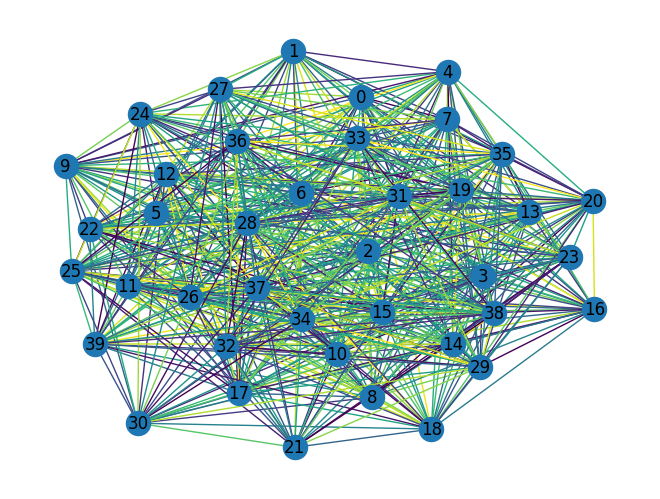

In [114]:
randomGraphs(40,0.8)

Best:  lsFirst, shakingConf, time: 0.3446676731109619. No. of conflicts 0


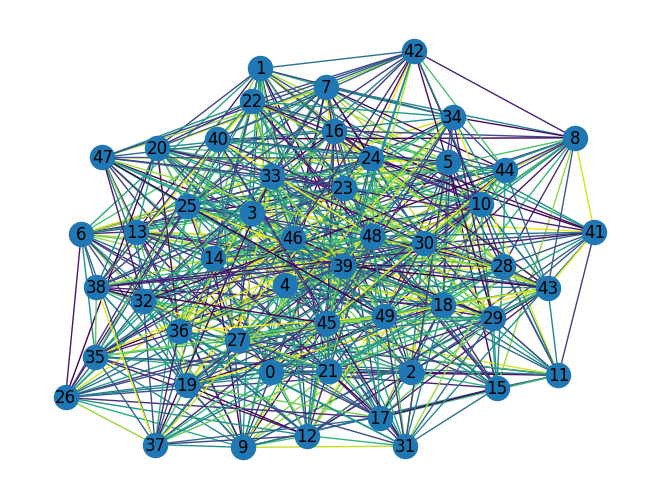

In [115]:
randomGraphs(50,0.5)

Best:  lsFirst, shakingRand, time: 3.9052276611328125. No. of conflicts 0


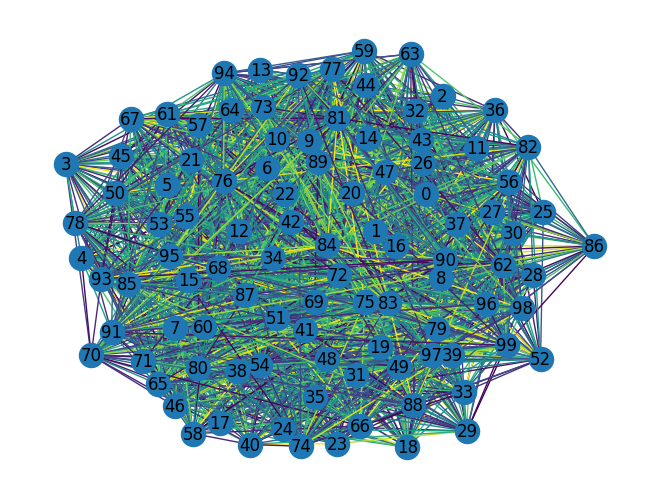

In [125]:
randomGraphs(100,0.5) #no lsBest, lsTabu, 2400+ edges

Random Regular Graphs: d degree of each node and n number of nodes.

In [54]:
def randomRegGraphs(d, n):
    vnsParams['neighbours'] = 10
    vnsParams['prob'] = 0.3

    name = f'randomGraph{d}_{n}.txt'

    graph = nx.random_regular_graph(d, n)
    saveGraph(name, graph)
    
    # res = testRandomGraph(graph,name, vnsParams, False)
    # if res != 0:
    #     _ = testRandomGraph(graph, name, vnsParams, True)
        


Best:  lsBest, shakingConf, time: 0.1987617015838623. No. of conflicts 0


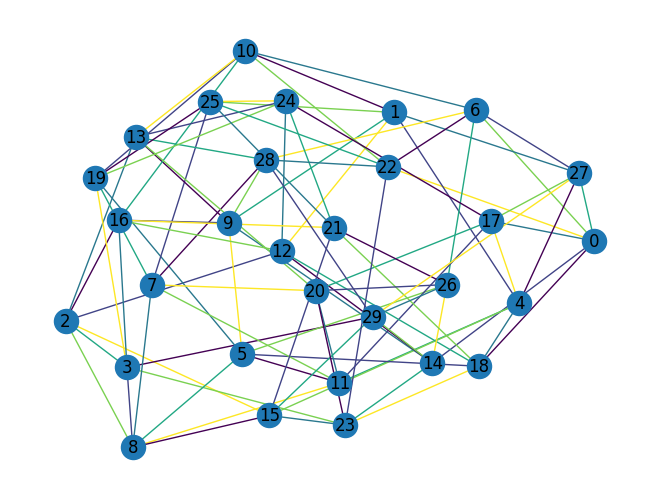

In [97]:
randomRegGraphs(6,30)

Best:  lsBest, shakingConf, time: 0.4954061508178711. No. of conflicts 0


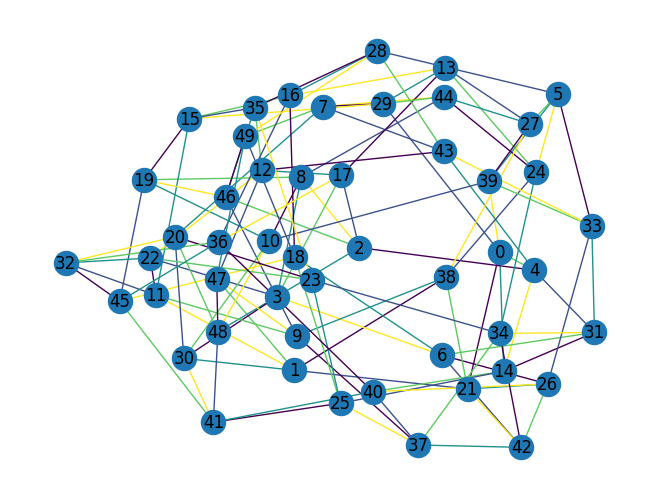

In [100]:
randomRegGraphs(5,50)

Best:  lsFirst, shakingConf, time: 5.489520311355591. No. of conflicts 0


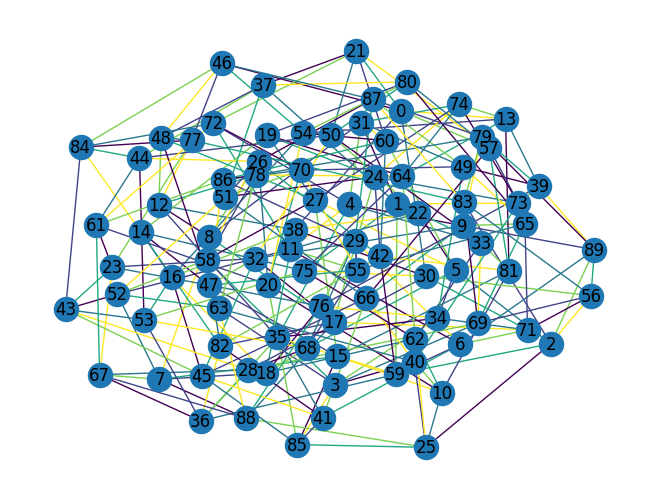

In [99]:
randomRegGraphs(6,90)

Testing theorems

Complete graphs K(n): If n is even then χ′ = Δ = n - 1, else χ′ = Δ + 1 = n

In [58]:
def completeGraph(n):
    vnsParams['neighbours'] = 4
    vnsParams['prob'] = 0.1 

    name = f'completeGraph{n}.txt'

    graph = nx.complete_graph(n)
    saveGraph(name, graph)
    
    # res = testRandomGraph(graph, name, vnsParams, False)
    # if res != 0:
    #     _ = testRandomGraph(graph, name, vnsParams, True)

Best:  lsFirst, shakingRand, time: 60.00046944618225. No. of conflicts 5
Best:  lsTabu, shakingSwap, time: 0.02741408348083496. No. of conflicts 0


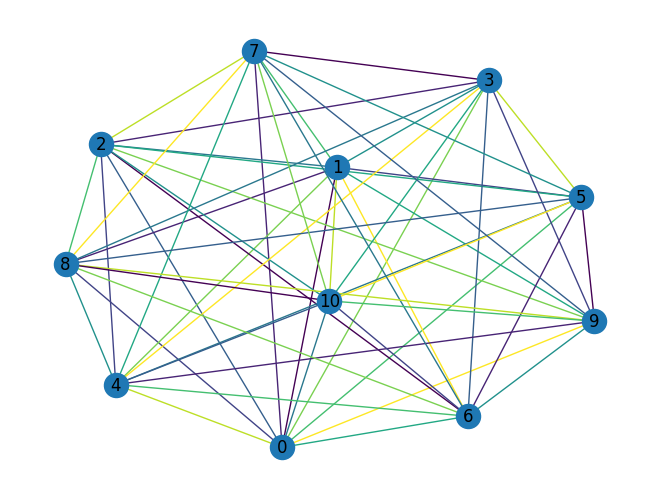

In [93]:
completeGraph(11)

Best:  lsBest, shakingConf, time: 5.767329692840576. No. of conflicts 0


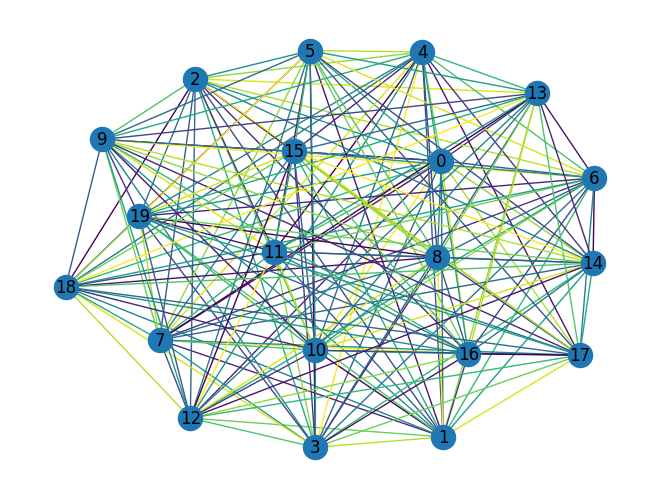

In [94]:
completeGraph(20)

Bipartite graphs G(n1,n2): χ′ = Δ

In [61]:
def bipartiteGraph(n):
    vnsParams['neighbours'] = 4
    vnsParams['prob'] = 0.1

    name  = f'completeBipartite{n}.txt'

    graph = nx.complete_bipartite_graph(n,n)
    saveGraph(name, graph)
    
    # _ = testRandomGraph(graph, name, vnsParams, False)


Best:  lsBest, shakingConf, time: 0.17133164405822754. No. of conflicts 0


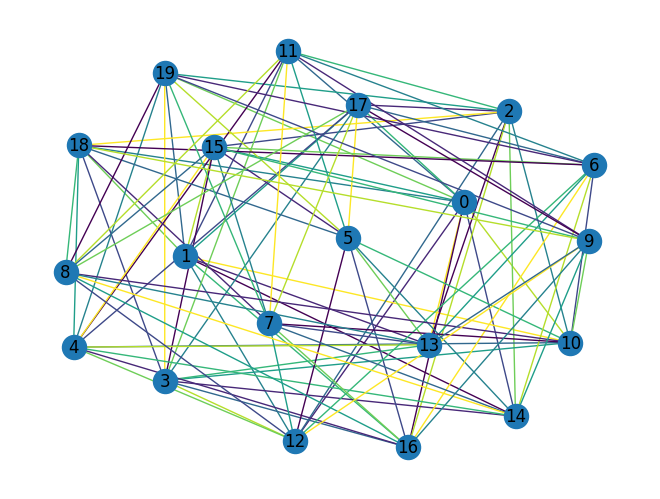

In [88]:
bipartiteGraph(10)

Best:  lsFirst, shakingConf, time: 23.28513741493225. No. of conflicts 0


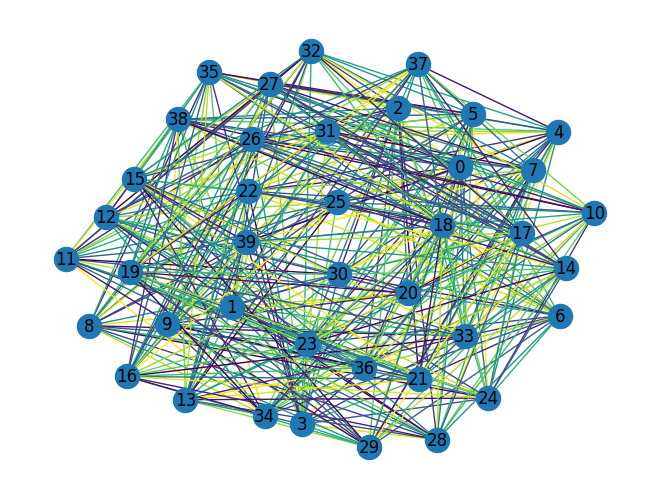

In [89]:
bipartiteGraph(20)

SNARK Graphs: Class 2 graphs, χ′ = Δ + 1

In [82]:
def snarkGraph(graph, name):
    vnsParams['neighbours'] = 7
    vnsParams['prob'] = 0.2
    
    res = testRandomGraph(graph, f'{name}.txt',vnsParams, False)
    if res != 0:
        _ = testRandomGraph(graph, f'{name}.txt', vnsParams, True)

Best:  lsBest, shakingConf, time: 60.00006580352783. No. of conflicts 2
Best:  lsFirst, shakingNeigh, time: 0.00012421607971191406. No. of conflicts 0


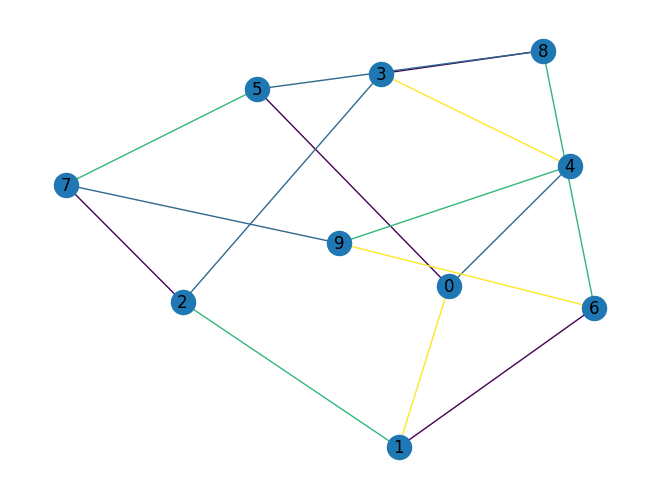

In [83]:
graph = nx.petersen_graph()
snarkGraph(graph, "petersen")

Best:  lsFirst, shakingNeigh, time: 60.00012135505676. No. of conflicts 2
Best:  lsFirst, shakingNeigh, time: 0.00019693374633789062. No. of conflicts 0


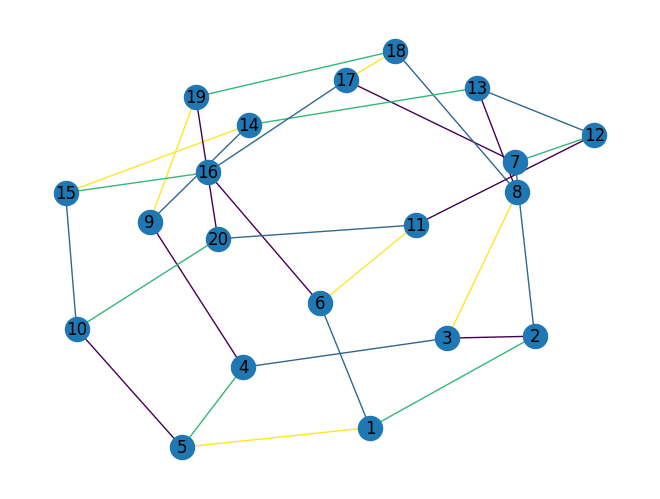

In [ ]:
graph = readGraph("tests/experimentalTests/flowerSnark.txt")
snarkGraph(graph, "flowerJ5")